In [1]:
import anndata as ad
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from scipy.optimize import linear_sum_assignment

import sys
sys.path.append('..')
import copy as copy
import torch


In [2]:
from src.interface import UnitedNet
from src.configs import *
from src.modules import Model, MLP, WeightedMeanFuser

In [3]:
def partitions(celltype, n_partitions, seed=0):
    """
    adapted from https://github.com/AllenInstitute/coupledAE-patchseq
    """
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning)

    # Safe to ignore warning - there are celltypes with a low sample number that are not crucial for the analysis.
    with warnings.catch_warnings():
        skf = StratifiedKFold(n_splits=n_partitions, random_state=seed, shuffle=True)

    # Get all partition indices from the sklearn generator:
    ind_dict = [{'train': train_ind, 'val': val_ind} for train_ind, val_ind in
                skf.split(X=np.zeros(shape=celltype.shape), y=celltype)]
    return ind_dict
    

In [4]:
def pre_ps(adata_rna_raw,adata_ephys_raw,adata_morph_raw,cv,split=False):
  adata_rna,adata_ephys,adata_morph = adata_rna_raw.copy(),adata_ephys_raw.copy(),adata_morph_raw.copy()
  adatas_train,adatas_test = [],[]
  assert (adata_rna.X>=0).all(), "poluted input"
  for mod in [adata_rna,adata_ephys,adata_morph]:
    mod.obs['label'] = mod.obs['cell_type_TEM']
    if split:
      m_train = mod[ind_dict[cv]['train']]
      scaler = preprocessing.StandardScaler().fit(m_train.X)
      m_train.X = scaler.transform(m_train.X)

      m_test = mod[ind_dict[cv]['val']]
      scaler = preprocessing.StandardScaler().fit(m_test.X)
      m_test.X = scaler.transform(m_test.X)
    else:
      scaler = preprocessing.StandardScaler().fit(mod.X)
      mod.X = scaler.transform(mod.X)
      m_train = mod[ind_dict[cv]['train']]
      m_test = mod[ind_dict[cv]['val']]

    adatas_train.append(m_train)
    adatas_test.append(m_test)
  adatas_all = [ad.concat([m_train,m_test]) for m_train,m_test in zip(adatas_train,adatas_test)]
  return adatas_train,adatas_test,adatas_all

# load input patch-seq data

In [5]:
technique = 'patchseq'
data_path = f"../data/{technique}"
device = "mps"
root_save_path = f"../saved_results/{technique}"
#load data
adata_rna_raw = sc.read_h5ad(f'{data_path}/adata_RNA_TEM.h5ad')
adata_ephys_raw = sc.read_h5ad(f'{data_path}/adata_Ephys_TEM.h5ad')
adata_morph_raw = sc.read_h5ad(f'{data_path}/adata_Morph_TEM.h5ad')
# Change this to a 5 fold for speed
ind_dict = partitions(adata_rna_raw.obs['cell_type_TEM'], n_partitions=2, seed=0)


In [12]:
for cv in range(2):
  adatas_train,adatas_test,_ = pre_ps(adata_rna_raw,adata_ephys_raw,adata_morph_raw,cv,split=True)
  root_save_path = f"./saved_results/{technique}_{cv}"
  model = UnitedNet(root_save_path, device=device, technique=patchseq_config)
  model.train(adatas_train,adatas_val = adatas_test)

  print(model.evaluate(adatas_test))
  _,_,adatas_all = pre_ps(adata_rna_raw,adata_ephys_raw,adata_morph_raw,cv,split=False)
  model.load_model(f"{root_save_path}/train_best.pt",device=torch.device(device))
  model.model.device_in_use = device
  model.model.config['train_task'] = "unsupervised_group_identification"
  model.model.config['train_epochs'] = 20
  model.train(adatas_all,verbose=True,init_classify=True)
  
  

training
EHHHHHHH
EHHHHHHH


100%|██████████| 20/20 [00:49<00:00,  2.47s/it]


{'r2': array([[ 0.1896548 ,  0.10806696,  0.0617539 ],
       [ 0.254814  ,  0.58275843,  0.01733289],
       [ 0.10685198, -0.00655607,  0.4665814 ]]), 'confusion': array([[16,  1,  2,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,
         0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  3,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  3,  8,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,
         0,  0,  0,  0,  0,  3,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 

  0%|          | 0/20 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.145611
ddc_loss_head_8            0.146472
ddc_loss_head_0            0.144904
ddc_loss_head_1            0.143423
ddc_loss_head_7            0.144563
reconstruction_loss        0.589655
self_entropy_loss_head_0  -0.031918
ddc_loss_head_3            0.144303
self_entropy_loss_head_2  -0.0313625
self_entropy_loss_head_8  -0.0317409
self_entropy_loss_head_4  -0.0317461
ddc_loss_head_9            0.145317
self_entropy_loss_head_5  -0.0318888
self_entropy_loss_head_3  -0.0316541
self_entropy_loss_head_1  -0.0314976
self_entropy_loss_head_9  -0.0314662
self_entropy_loss_head_7  -0.031584
ddc_loss_head_2            0.142523
self_entropy_loss_head_6  -0.0314731
ddc_loss_head_5            0.146179
ddc_loss_head_4            0.143957
best_head                  2
best model saved at ./saved_results/patchseq_0/train_best.pt 

model saved at ./saved_results/patchseq_0/train_epoch_1.pt 



  5%|▌         | 1/20 [00:06<02:01,  6.41s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.32589285714285715
ari        0.19841047164949682
nmi        0.5627137305277231


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.135699
ddc_loss_head_8            0.135571
ddc_loss_head_0            0.135139
ddc_loss_head_1            0.135361
ddc_loss_head_7            0.134711
reconstruction_loss        0.550212
self_entropy_loss_head_0  -0.0316291
ddc_loss_head_3            0.133605
self_entropy_loss_head_2  -0.0314291
self_entropy_loss_head_8  -0.0314581
self_entropy_loss_head_4  -0.0316098
ddc_loss_head_9            0.135119
self_entropy_loss_head_5  -0.0316194
self_entropy_loss_head_3  -0.0314193
self_entropy_loss_head_1  -0.0313763
self_entropy_loss_head_9  -0.0312366
self_entropy_loss_head_7  -0.0314114
ddc_loss_head_2            0.134572
self_entropy_loss_head_6  -0.0314805
ddc_loss_head_5       

 10%|█         | 2/20 [00:13<01:58,  6.59s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.4017857142857143
ari        0.2915197208890627
nmi        0.5898793760236213


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.131968
ddc_loss_head_8            0.131676
ddc_loss_head_0            0.131458
ddc_loss_head_1            0.132589
ddc_loss_head_7            0.131131
reconstruction_loss        0.523754
self_entropy_loss_head_0  -0.0312579
ddc_loss_head_3            0.129967
self_entropy_loss_head_2  -0.031338
self_entropy_loss_head_8  -0.0313081
self_entropy_loss_head_4  -0.0313583
ddc_loss_head_9            0.131535
self_entropy_loss_head_5  -0.0311425
self_entropy_loss_head_3  -0.0312946
self_entropy_loss_head_1  -0.0313547
self_entropy_loss_head_9  -0.0311053
self_entropy_loss_head_7  -0.0311667
ddc_loss_head_2            0.132118
self_entropy_loss_head_6  -0.031177
ddc_loss_head_5           

 15%|█▌        | 3/20 [00:19<01:50,  6.52s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.4174107142857143
ari        0.28776504024756167
nmi        0.5934024788076989


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.129555
ddc_loss_head_8            0.128896
ddc_loss_head_0            0.129124
ddc_loss_head_1            0.13053
ddc_loss_head_7            0.129029
reconstruction_loss        0.507449
self_entropy_loss_head_0  -0.0310126
ddc_loss_head_3            0.127961
self_entropy_loss_head_2  -0.0313195
self_entropy_loss_head_8  -0.0311028
self_entropy_loss_head_4  -0.0310155
ddc_loss_head_9            0.129831
self_entropy_loss_head_5  -0.0310744
self_entropy_loss_head_3  -0.0310575
self_entropy_loss_head_1  -0.0311696
self_entropy_loss_head_9  -0.0310399
self_entropy_loss_head_7  -0.030983
ddc_loss_head_2            0.130806
self_entropy_loss_head_6  -0.0310348
ddc_loss_head_5          

 20%|██        | 4/20 [00:26<01:44,  6.52s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.390625
ari        0.2864044492039204
nmi        0.6110308756501013


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.127653
ddc_loss_head_8            0.12673
ddc_loss_head_0            0.127445
ddc_loss_head_1            0.128344
ddc_loss_head_7            0.127523
reconstruction_loss        0.480634
self_entropy_loss_head_0  -0.0308378
ddc_loss_head_3            0.126626
self_entropy_loss_head_2  -0.0311177
self_entropy_loss_head_8  -0.030936
self_entropy_loss_head_4  -0.030784
ddc_loss_head_9            0.127812
self_entropy_loss_head_5  -0.0309688
self_entropy_loss_head_3  -0.0308517
self_entropy_loss_head_1  -0.0309338
self_entropy_loss_head_9  -0.0308945
self_entropy_loss_head_7  -0.0308303
ddc_loss_head_2            0.129352
self_entropy_loss_head_6  -0.030898
ddc_loss_head_5            0.129273
dd

 25%|██▌       | 5/20 [00:32<01:37,  6.49s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.39732142857142855
ari        0.3038367462164221
nmi        0.6247520038129466


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.126111
ddc_loss_head_8            0.125049
ddc_loss_head_0            0.12616
ddc_loss_head_1            0.126586
ddc_loss_head_7            0.125927
reconstruction_loss        0.462725
self_entropy_loss_head_0  -0.0307297
ddc_loss_head_3            0.12515
self_entropy_loss_head_2  -0.0310855
self_entropy_loss_head_8  -0.0308261
self_entropy_loss_head_4  -0.0306626
ddc_loss_head_9            0.126137
self_entropy_loss_head_5  -0.0310419
self_entropy_loss_head_3  -0.0307706
self_entropy_loss_head_1  -0.0308933
self_entropy_loss_head_9  -0.0308553
self_entropy_loss_head_7  -0.0307054
ddc_loss_head_2            0.128083
self_entropy_loss_head_6  -0.0309438
ddc_loss_head_5          

 30%|███       | 6/20 [00:39<01:31,  6.55s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.41517857142857145
ari        0.3089207786133685
nmi        0.6259534018390066


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.124618
ddc_loss_head_8            0.123618
ddc_loss_head_0            0.124476
ddc_loss_head_1            0.125238
ddc_loss_head_7            0.124806
reconstruction_loss        0.440509
self_entropy_loss_head_0  -0.0304264
ddc_loss_head_3            0.124147
self_entropy_loss_head_2  -0.0307601
self_entropy_loss_head_8  -0.0305367
self_entropy_loss_head_4  -0.0303802
ddc_loss_head_9            0.125304
self_entropy_loss_head_5  -0.0308775
self_entropy_loss_head_3  -0.0306458
self_entropy_loss_head_1  -0.0307931
self_entropy_loss_head_9  -0.0306473
self_entropy_loss_head_7  -0.0305613
ddc_loss_head_2            0.126754
self_entropy_loss_head_6  -0.0307412
ddc_loss_head_5        

 35%|███▌      | 7/20 [00:45<01:25,  6.58s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.43526785714285715
ari        0.32642481454659383
nmi        0.6389453134922475


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.122904
ddc_loss_head_8            0.122335
ddc_loss_head_0            0.122987
ddc_loss_head_1            0.123512
ddc_loss_head_7            0.12341
reconstruction_loss        0.421142
self_entropy_loss_head_0  -0.0302323
ddc_loss_head_3            0.122729
self_entropy_loss_head_2  -0.0306518
self_entropy_loss_head_8  -0.0303624
self_entropy_loss_head_4  -0.030089
ddc_loss_head_9            0.123377
self_entropy_loss_head_5  -0.0306492
self_entropy_loss_head_3  -0.030451
self_entropy_loss_head_1  -0.0305598
self_entropy_loss_head_9  -0.0304901
self_entropy_loss_head_7  -0.0302725
ddc_loss_head_2            0.124864
self_entropy_loss_head_6  -0.0307038
ddc_loss_head_5          

 40%|████      | 8/20 [00:52<01:18,  6.52s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.4486607142857143
ari        0.3529967743269115
nmi        0.6430319560551849


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.121894
ddc_loss_head_8            0.12127
ddc_loss_head_0            0.122014
ddc_loss_head_1            0.122052
ddc_loss_head_7            0.122591
reconstruction_loss        0.401773
self_entropy_loss_head_0  -0.0300733
ddc_loss_head_3            0.12169
self_entropy_loss_head_2  -0.0304097
self_entropy_loss_head_8  -0.0302365
self_entropy_loss_head_4  -0.0299403
ddc_loss_head_9            0.122162
self_entropy_loss_head_5  -0.0305285
self_entropy_loss_head_3  -0.0302792
self_entropy_loss_head_1  -0.0302861
self_entropy_loss_head_9  -0.0304259
self_entropy_loss_head_7  -0.030165
ddc_loss_head_2            0.123055
self_entropy_loss_head_6  -0.0304371
ddc_loss_head_5            

 45%|████▌     | 9/20 [00:58<01:11,  6.46s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.43526785714285715
ari        0.3145982615403459
nmi        0.6334558423303723


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.120944
ddc_loss_head_8            0.120698
ddc_loss_head_0            0.120816
ddc_loss_head_1            0.121189
ddc_loss_head_7            0.122105
reconstruction_loss        0.387465
self_entropy_loss_head_0  -0.0298852
ddc_loss_head_3            0.121031
self_entropy_loss_head_2  -0.0302537
self_entropy_loss_head_8  -0.0300733
self_entropy_loss_head_4  -0.0298623
ddc_loss_head_9            0.121154
self_entropy_loss_head_5  -0.0301482
self_entropy_loss_head_3  -0.0300718
self_entropy_loss_head_1  -0.0301656
self_entropy_loss_head_9  -0.0301479
self_entropy_loss_head_7  -0.0300434
ddc_loss_head_2            0.122179
self_entropy_loss_head_6  -0.0302609
ddc_loss_head_5        

 50%|█████     | 10/20 [01:04<01:04,  6.42s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.4330357142857143
ari        0.33085853451554204
nmi        0.6452839994555019


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.12015
ddc_loss_head_8            0.120031
ddc_loss_head_0            0.120085
ddc_loss_head_1            0.120187
ddc_loss_head_7            0.121093
reconstruction_loss        0.382053
self_entropy_loss_head_0  -0.0296623
ddc_loss_head_3            0.120134
self_entropy_loss_head_2  -0.0300616
self_entropy_loss_head_8  -0.029989
self_entropy_loss_head_4  -0.0296675
ddc_loss_head_9            0.120364
self_entropy_loss_head_5  -0.0300586
self_entropy_loss_head_3  -0.029843
self_entropy_loss_head_1  -0.0299172
self_entropy_loss_head_9  -0.030025
self_entropy_loss_head_7  -0.0299338
ddc_loss_head_2            0.120724
self_entropy_loss_head_6  -0.0300425
ddc_loss_head_5            

 55%|█████▌    | 11/20 [01:11<00:57,  6.39s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.47098214285714285
ari        0.36503761428822634
nmi        0.6546293456547576


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.119653
ddc_loss_head_8            0.119264
ddc_loss_head_0            0.119416
ddc_loss_head_1            0.119491
ddc_loss_head_7            0.120464
reconstruction_loss        0.373364
self_entropy_loss_head_0  -0.0296259
ddc_loss_head_3            0.119552
self_entropy_loss_head_2  -0.0299344
self_entropy_loss_head_8  -0.0297277
self_entropy_loss_head_4  -0.0294398
ddc_loss_head_9            0.120008
self_entropy_loss_head_5  -0.0300084
self_entropy_loss_head_3  -0.0297754
self_entropy_loss_head_1  -0.0296365
self_entropy_loss_head_9  -0.0298812
self_entropy_loss_head_7  -0.0297808
ddc_loss_head_2            0.120336
self_entropy_loss_head_6  -0.0299728
ddc_loss_head_5       

 60%|██████    | 12/20 [01:17<00:51,  6.48s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.45089285714285715
ari        0.34028740802613294
nmi        0.6481255194137728


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.118463
ddc_loss_head_8            0.118432
ddc_loss_head_0            0.11854
ddc_loss_head_1            0.118433
ddc_loss_head_7            0.119439
reconstruction_loss        0.357879
self_entropy_loss_head_0  -0.0292304
ddc_loss_head_3            0.11895
self_entropy_loss_head_2  -0.0296614
self_entropy_loss_head_8  -0.0294964
self_entropy_loss_head_4  -0.0291242
ddc_loss_head_9            0.118964
self_entropy_loss_head_5  -0.0297276
self_entropy_loss_head_3  -0.0295191
self_entropy_loss_head_1  -0.0293588
self_entropy_loss_head_9  -0.0295151
self_entropy_loss_head_7  -0.0294654
ddc_loss_head_2            0.119091
self_entropy_loss_head_6  -0.0296395
ddc_loss_head_5         

 65%|██████▌   | 13/20 [01:24<00:45,  6.49s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.47098214285714285
ari        0.3635988278974103
nmi        0.6596016300950173


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.117753
ddc_loss_head_8            0.117967
ddc_loss_head_0            0.118037
ddc_loss_head_1            0.1176
ddc_loss_head_7            0.118874
reconstruction_loss        0.34245
self_entropy_loss_head_0  -0.0291495
ddc_loss_head_3            0.118534
self_entropy_loss_head_2  -0.0295132
self_entropy_loss_head_8  -0.0292419
self_entropy_loss_head_4  -0.0289086
ddc_loss_head_9            0.118138
self_entropy_loss_head_5  -0.0295527
self_entropy_loss_head_3  -0.0293259
self_entropy_loss_head_1  -0.0289486
self_entropy_loss_head_9  -0.0292356
self_entropy_loss_head_7  -0.0294127
ddc_loss_head_2            0.118551
self_entropy_loss_head_6  -0.0293485
ddc_loss_head_5           

 70%|███████   | 14/20 [01:30<00:39,  6.50s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.4888392857142857
ari        0.37741514160018697
nmi        0.6686177800323402


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.116833
ddc_loss_head_8            0.116941
ddc_loss_head_0            0.116913
ddc_loss_head_1            0.116561
ddc_loss_head_7            0.117714
reconstruction_loss        0.32363
self_entropy_loss_head_0  -0.0286619
ddc_loss_head_3            0.117583
self_entropy_loss_head_2  -0.0291892
self_entropy_loss_head_8  -0.0288642
self_entropy_loss_head_4  -0.0284558
ddc_loss_head_9            0.117623
self_entropy_loss_head_5  -0.0293654
self_entropy_loss_head_3  -0.0291331
self_entropy_loss_head_1  -0.0285609
self_entropy_loss_head_9  -0.0290596
self_entropy_loss_head_7  -0.0291439
ddc_loss_head_2            0.117747
self_entropy_loss_head_6  -0.02903
ddc_loss_head_5           

 75%|███████▌  | 15/20 [01:37<00:32,  6.50s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.5133928571428571
ari        0.39801551391209616
nmi        0.6681163086745234


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.115764
ddc_loss_head_8            0.115567
ddc_loss_head_0            0.116011
ddc_loss_head_1            0.115641
ddc_loss_head_7            0.116429
reconstruction_loss        0.312972
self_entropy_loss_head_0  -0.0285265
ddc_loss_head_3            0.116919
self_entropy_loss_head_2  -0.0289026
self_entropy_loss_head_8  -0.0286081
self_entropy_loss_head_4  -0.0281952
ddc_loss_head_9            0.116434
self_entropy_loss_head_5  -0.0291698
self_entropy_loss_head_3  -0.028789
self_entropy_loss_head_1  -0.0283748
self_entropy_loss_head_9  -0.0287309
self_entropy_loss_head_7  -0.0288312
ddc_loss_head_2            0.117018
self_entropy_loss_head_6  -0.0287388
ddc_loss_head_5         

 80%|████████  | 16/20 [01:44<00:26,  6.52s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.5513392857142857
ari        0.44916857076046995
nmi        0.6757603197978936


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.115127
ddc_loss_head_8            0.115046
ddc_loss_head_0            0.11511
ddc_loss_head_1            0.114816
ddc_loss_head_7            0.115623
reconstruction_loss        0.29831
self_entropy_loss_head_0  -0.0283386
ddc_loss_head_3            0.116502
self_entropy_loss_head_2  -0.0286903
self_entropy_loss_head_8  -0.0285368
self_entropy_loss_head_4  -0.0276859
ddc_loss_head_9            0.115858
self_entropy_loss_head_5  -0.028905
self_entropy_loss_head_3  -0.0286961
self_entropy_loss_head_1  -0.0280011
self_entropy_loss_head_9  -0.0284991
self_entropy_loss_head_7  -0.0286678
ddc_loss_head_2            0.116238
self_entropy_loss_head_6  -0.0285906
ddc_loss_head_5           

 85%|████████▌ | 17/20 [01:50<00:19,  6.61s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.5379464285714286
ari        0.4389322957561736
nmi        0.6717943872594097


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.11433
ddc_loss_head_8            0.114419
ddc_loss_head_0            0.114113
ddc_loss_head_1            0.11405
ddc_loss_head_7            0.1153
reconstruction_loss        0.283719
self_entropy_loss_head_0  -0.0278202
ddc_loss_head_3            0.115597
self_entropy_loss_head_2  -0.0281315
self_entropy_loss_head_8  -0.028053
self_entropy_loss_head_4  -0.027186
ddc_loss_head_9            0.115161
self_entropy_loss_head_5  -0.0286766
self_entropy_loss_head_3  -0.0282827
self_entropy_loss_head_1  -0.0277662
self_entropy_loss_head_9  -0.028182
self_entropy_loss_head_7  -0.028271
ddc_loss_head_2            0.115364
self_entropy_loss_head_6  -0.0281774
ddc_loss_head_5            0.116

 90%|█████████ | 18/20 [01:57<00:13,  6.68s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.5424107142857143
ari        0.4414258394575061
nmi        0.6745072068801666


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.113438
ddc_loss_head_8            0.113779
ddc_loss_head_0            0.112887
ddc_loss_head_1            0.113623
ddc_loss_head_7            0.114253
reconstruction_loss        0.283661
self_entropy_loss_head_0  -0.0271544
ddc_loss_head_3            0.114887
self_entropy_loss_head_2  -0.0278347
self_entropy_loss_head_8  -0.0277718
self_entropy_loss_head_4  -0.0270112
ddc_loss_head_9            0.114468
self_entropy_loss_head_5  -0.0284711
self_entropy_loss_head_3  -0.0279611
self_entropy_loss_head_1  -0.0276211
self_entropy_loss_head_9  -0.0278494
self_entropy_loss_head_7  -0.0281163
ddc_loss_head_2            0.114465
self_entropy_loss_head_6  -0.0277921
ddc_loss_head_5         

 95%|█████████▌| 19/20 [02:04<00:06,  6.68s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.5245535714285714
ari        0.4331382402655897
nmi        0.6717603513312457


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.112423
ddc_loss_head_8            0.11299
ddc_loss_head_0            0.11196
ddc_loss_head_1            0.112878
ddc_loss_head_7            0.113229
reconstruction_loss        0.269441
self_entropy_loss_head_0  -0.0266296
ddc_loss_head_3            0.113912
self_entropy_loss_head_2  -0.0273192
self_entropy_loss_head_8  -0.0271931
self_entropy_loss_head_4  -0.0268513
ddc_loss_head_9            0.113953
self_entropy_loss_head_5  -0.0282456
self_entropy_loss_head_3  -0.0275069
self_entropy_loss_head_1  -0.0273721
self_entropy_loss_head_9  -0.027459
self_entropy_loss_head_7  -0.0277339
ddc_loss_head_2            0.113574
self_entropy_loss_head_6  -0.0273341
ddc_loss_head_5            

100%|██████████| 20/20 [02:10<00:00,  6.54s/it]




Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.5267857142857143
ari        0.4342482876304572
nmi        0.6698400091804396
training
EHHHHHHH
EHHHHHHH


100%|██████████| 20/20 [00:49<00:00,  2.48s/it]


{'r2': array([[ 0.18634206,  0.09419443,  0.06374687],
       [ 0.18589303,  0.5648303 , -0.00670172],
       [ 0.10002041, -0.03022631,  0.4328782 ]]), 'confusion': array([[11, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  3,  6,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,
         0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 

  0%|          | 0/20 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.144009
ddc_loss_head_8            0.145732
ddc_loss_head_0            0.147494
ddc_loss_head_1            0.146296
ddc_loss_head_7            0.145891
reconstruction_loss        0.63262
self_entropy_loss_head_0  -0.0316885
ddc_loss_head_3            0.145827
self_entropy_loss_head_2  -0.0318135
self_entropy_loss_head_8  -0.0316368
self_entropy_loss_head_4  -0.0316061
ddc_loss_head_9            0.148132
self_entropy_loss_head_5  -0.0315581
self_entropy_loss_head_3  -0.0315186
self_entropy_loss_head_1  -0.0316232
self_entropy_loss_head_9  -0.0317984
self_entropy_loss_head_7  -0.0317772
ddc_loss_head_2            0.146416
self_entropy_loss_head_6  -0.031638
ddc_loss_head_5            0.146485
ddc_loss_head_4            0.146537
best_head                  6
best model saved at ./saved_results/patchseq_1/train_best.pt 

model saved at ./saved_results/patchseq_1/train_epoch_1.pt 



  5%|▌         | 1/20 [00:06<02:05,  6.62s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.40625
ari        0.2747264098333246
nmi        0.5655994646821304


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.135311
ddc_loss_head_8            0.135844
ddc_loss_head_0            0.134744
ddc_loss_head_1            0.134356
ddc_loss_head_7            0.134679
reconstruction_loss        0.573303
self_entropy_loss_head_0  -0.0314519
ddc_loss_head_3            0.135082
self_entropy_loss_head_2  -0.0314274
self_entropy_loss_head_8  -0.031385
self_entropy_loss_head_4  -0.0313962
ddc_loss_head_9            0.13525
self_entropy_loss_head_5  -0.0313483
self_entropy_loss_head_3  -0.031404
self_entropy_loss_head_1  -0.0315785
self_entropy_loss_head_9  -0.0316396
self_entropy_loss_head_7  -0.0315663
ddc_loss_head_2            0.134149
self_entropy_loss_head_6  -0.0314364
ddc_loss_head_5            0.136077
dd

 10%|█         | 2/20 [00:13<02:04,  6.90s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.3861607142857143
ari        0.30594876176991215
nmi        0.5812034655130534


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.131493
ddc_loss_head_8            0.131194
ddc_loss_head_0            0.129183
ddc_loss_head_1            0.128767
ddc_loss_head_7            0.128968
reconstruction_loss        0.53453
self_entropy_loss_head_0  -0.0310523
ddc_loss_head_3            0.129191
self_entropy_loss_head_2  -0.0311124
self_entropy_loss_head_8  -0.031211
self_entropy_loss_head_4  -0.0311761
ddc_loss_head_9            0.129798
self_entropy_loss_head_5  -0.031367
self_entropy_loss_head_3  -0.0312265
self_entropy_loss_head_1  -0.0313628
self_entropy_loss_head_9  -0.0313922
self_entropy_loss_head_7  -0.0313321
ddc_loss_head_2            0.128552
self_entropy_loss_head_6  -0.0313583
ddc_loss_head_5           

 15%|█▌        | 3/20 [00:20<01:57,  6.90s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.421875
ari        0.32577816277894467
nmi        0.5918201846953111


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.12788
ddc_loss_head_8            0.128297
ddc_loss_head_0            0.125959
ddc_loss_head_1            0.125998
ddc_loss_head_7            0.126249
reconstruction_loss        0.508001
self_entropy_loss_head_0  -0.0307174
ddc_loss_head_3            0.126639
self_entropy_loss_head_2  -0.0309186
self_entropy_loss_head_8  -0.0310262
self_entropy_loss_head_4  -0.0309534
ddc_loss_head_9            0.126748
self_entropy_loss_head_5  -0.0311203
self_entropy_loss_head_3  -0.0311754
self_entropy_loss_head_1  -0.0310656
self_entropy_loss_head_9  -0.0311467
self_entropy_loss_head_7  -0.0310258
ddc_loss_head_2            0.125775
self_entropy_loss_head_6  -0.0311763
ddc_loss_head_5            0.12857

 20%|██        | 4/20 [00:27<01:49,  6.87s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.42857142857142855
ari        0.31165635638685407
nmi        0.6060833702658085


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.125297
ddc_loss_head_8            0.125663
ddc_loss_head_0            0.123663
ddc_loss_head_1            0.124104
ddc_loss_head_7            0.124204
reconstruction_loss        0.489791
self_entropy_loss_head_0  -0.0303801
ddc_loss_head_3            0.124533
self_entropy_loss_head_2  -0.0306397
self_entropy_loss_head_8  -0.0307256
self_entropy_loss_head_4  -0.0307136
ddc_loss_head_9            0.124533
self_entropy_loss_head_5  -0.0308924
self_entropy_loss_head_3  -0.030892
self_entropy_loss_head_1  -0.0308772
self_entropy_loss_head_9  -0.0308627
self_entropy_loss_head_7  -0.0307479
ddc_loss_head_2            0.124076
self_entropy_loss_head_6  -0.0309488
ddc_loss_head_5        

 25%|██▌       | 5/20 [00:34<01:41,  6.79s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.44419642857142855
ari        0.30590511101512535
nmi        0.6077647460453167


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.123632
ddc_loss_head_8            0.123828
ddc_loss_head_0            0.121955
ddc_loss_head_1            0.122786
ddc_loss_head_7            0.122492
reconstruction_loss        0.46588
self_entropy_loss_head_0  -0.030128
ddc_loss_head_3            0.123303
self_entropy_loss_head_2  -0.0305503
self_entropy_loss_head_8  -0.030469
self_entropy_loss_head_4  -0.0304165
ddc_loss_head_9            0.12302
self_entropy_loss_head_5  -0.0305209
self_entropy_loss_head_3  -0.0308029
self_entropy_loss_head_1  -0.0306935
self_entropy_loss_head_9  -0.0307236
self_entropy_loss_head_7  -0.0304779
ddc_loss_head_2            0.122747
self_entropy_loss_head_6  -0.0307639
ddc_loss_head_5           

 30%|███       | 6/20 [00:40<01:33,  6.71s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.44419642857142855
ari        0.3023304625425285
nmi        0.6135963376007177


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.122486
ddc_loss_head_8            0.122744
ddc_loss_head_0            0.121437
ddc_loss_head_1            0.121918
ddc_loss_head_7            0.12216
reconstruction_loss        0.453296
self_entropy_loss_head_0  -0.0299131
ddc_loss_head_3            0.12256
self_entropy_loss_head_2  -0.0302631
self_entropy_loss_head_8  -0.03024
self_entropy_loss_head_4  -0.0303791
ddc_loss_head_9            0.122221
self_entropy_loss_head_5  -0.0302261
self_entropy_loss_head_3  -0.0305305
self_entropy_loss_head_1  -0.0304507
self_entropy_loss_head_9  -0.030454
self_entropy_loss_head_7  -0.0303359
ddc_loss_head_2            0.122037
self_entropy_loss_head_6  -0.0305279
ddc_loss_head_5            0

 35%|███▌      | 7/20 [00:47<01:26,  6.67s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.4799107142857143
ari        0.3318536041612402
nmi        0.6267309614686052


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.121205
ddc_loss_head_8            0.121744
ddc_loss_head_0            0.120117
ddc_loss_head_1            0.121048
ddc_loss_head_7            0.12096
reconstruction_loss        0.430889
self_entropy_loss_head_0  -0.0296501
ddc_loss_head_3            0.121464
self_entropy_loss_head_2  -0.0301554
self_entropy_loss_head_8  -0.0300921
self_entropy_loss_head_4  -0.0302559
ddc_loss_head_9            0.121064
self_entropy_loss_head_5  -0.0300216
self_entropy_loss_head_3  -0.0303919
self_entropy_loss_head_1  -0.0303189
self_entropy_loss_head_9  -0.030345
self_entropy_loss_head_7  -0.0302453
ddc_loss_head_2            0.121032
self_entropy_loss_head_6  -0.0303752
ddc_loss_head_5           

 40%|████      | 8/20 [00:53<01:20,  6.67s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.45535714285714285
ari        0.3086927490597966
nmi        0.6173033201912418


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.120615
ddc_loss_head_8            0.121342
ddc_loss_head_0            0.119942
ddc_loss_head_1            0.120624
ddc_loss_head_7            0.120377
reconstruction_loss        0.43346
self_entropy_loss_head_0  -0.0295149
ddc_loss_head_3            0.121015
self_entropy_loss_head_2  -0.0299233
self_entropy_loss_head_8  -0.0300029
self_entropy_loss_head_4  -0.0301145
ddc_loss_head_9            0.120377
self_entropy_loss_head_5  -0.0297842
self_entropy_loss_head_3  -0.0301628
self_entropy_loss_head_1  -0.0301594
self_entropy_loss_head_9  -0.0300972
self_entropy_loss_head_7  -0.0301818
ddc_loss_head_2            0.120485
self_entropy_loss_head_6  -0.0301842
ddc_loss_head_5         

 45%|████▌     | 9/20 [01:00<01:14,  6.79s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.45535714285714285
ari        0.3061953454888318
nmi        0.6141519316440954


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.119677
ddc_loss_head_8            0.120589
ddc_loss_head_0            0.11882
ddc_loss_head_1            0.119619
ddc_loss_head_7            0.119649
reconstruction_loss        0.402737
self_entropy_loss_head_0  -0.02938
ddc_loss_head_3            0.120206
self_entropy_loss_head_2  -0.0299019
self_entropy_loss_head_8  -0.0298805
self_entropy_loss_head_4  -0.0299686
ddc_loss_head_9            0.119424
self_entropy_loss_head_5  -0.0295757
self_entropy_loss_head_3  -0.0300585
self_entropy_loss_head_1  -0.0299353
self_entropy_loss_head_9  -0.0299233
self_entropy_loss_head_7  -0.0299809
ddc_loss_head_2            0.119636
self_entropy_loss_head_6  -0.030032
ddc_loss_head_5            

 50%|█████     | 10/20 [01:07<01:08,  6.83s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.41964285714285715
ari        0.2735021096588929
nmi        0.596927495108195


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.119251
ddc_loss_head_8            0.119923
ddc_loss_head_0            0.11836
ddc_loss_head_1            0.119228
ddc_loss_head_7            0.119252
reconstruction_loss        0.390314
self_entropy_loss_head_0  -0.0292258
ddc_loss_head_3            0.119529
self_entropy_loss_head_2  -0.0297242
self_entropy_loss_head_8  -0.0297508
self_entropy_loss_head_4  -0.029867
ddc_loss_head_9            0.119002
self_entropy_loss_head_5  -0.0293818
self_entropy_loss_head_3  -0.0298441
self_entropy_loss_head_1  -0.0297141
self_entropy_loss_head_9  -0.0297779
self_entropy_loss_head_7  -0.0298002
ddc_loss_head_2            0.11921
self_entropy_loss_head_6  -0.0299049
ddc_loss_head_5            

 55%|█████▌    | 11/20 [01:14<01:00,  6.75s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.42857142857142855
ari        0.28001223439226114
nmi        0.6014085065458594


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.118537
ddc_loss_head_8            0.119374
ddc_loss_head_0            0.117956
ddc_loss_head_1            0.118735
ddc_loss_head_7            0.118813
reconstruction_loss        0.375068
self_entropy_loss_head_0  -0.0291458
ddc_loss_head_3            0.119091
self_entropy_loss_head_2  -0.0296529
self_entropy_loss_head_8  -0.0297006
self_entropy_loss_head_4  -0.029748
ddc_loss_head_9            0.11833
self_entropy_loss_head_5  -0.0293435
self_entropy_loss_head_3  -0.0295476
self_entropy_loss_head_1  -0.029583
self_entropy_loss_head_9  -0.0296415
self_entropy_loss_head_7  -0.0296521
ddc_loss_head_2            0.118594
self_entropy_loss_head_6  -0.0297315
ddc_loss_head_5          

 60%|██████    | 12/20 [01:20<00:53,  6.66s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.4330357142857143
ari        0.28653455602148015
nmi        0.6100893755990892


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.1177
ddc_loss_head_8            0.118632
ddc_loss_head_0            0.117529
ddc_loss_head_1            0.117622
ddc_loss_head_7            0.118253
reconstruction_loss        0.365694
self_entropy_loss_head_0  -0.0288819
ddc_loss_head_3            0.118319
self_entropy_loss_head_2  -0.0294671
self_entropy_loss_head_8  -0.0294783
self_entropy_loss_head_4  -0.029505
ddc_loss_head_9            0.11807
self_entropy_loss_head_5  -0.0291915
self_entropy_loss_head_3  -0.0294499
self_entropy_loss_head_1  -0.0293637
self_entropy_loss_head_9  -0.0294745
self_entropy_loss_head_7  -0.0294932
ddc_loss_head_2            0.117993
self_entropy_loss_head_6  -0.0294971
ddc_loss_head_5            

 65%|██████▌   | 13/20 [01:27<00:46,  6.67s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.453125
ari        0.30321388779298475
nmi        0.6166392184119711


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.116927
ddc_loss_head_8            0.117703
ddc_loss_head_0            0.116719
ddc_loss_head_1            0.117147
ddc_loss_head_7            0.117556
reconstruction_loss        0.355825
self_entropy_loss_head_0  -0.0286861
ddc_loss_head_3            0.117419
self_entropy_loss_head_2  -0.0292243
self_entropy_loss_head_8  -0.0291245
self_entropy_loss_head_4  -0.0293781
ddc_loss_head_9            0.117118
self_entropy_loss_head_5  -0.0290026
self_entropy_loss_head_3  -0.0291332
self_entropy_loss_head_1  -0.0290956
self_entropy_loss_head_9  -0.0292692
self_entropy_loss_head_7  -0.0293267
ddc_loss_head_2            0.117265
self_entropy_loss_head_6  -0.029286
ddc_loss_head_5            0.11715

 70%|███████   | 14/20 [01:34<00:39,  6.62s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.47767857142857145
ari        0.3245794746988896
nmi        0.6234383349264916


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.116643
ddc_loss_head_8            0.117308
ddc_loss_head_0            0.116503
ddc_loss_head_1            0.116871
ddc_loss_head_7            0.117028
reconstruction_loss        0.32939
self_entropy_loss_head_0  -0.0286903
ddc_loss_head_3            0.117136
self_entropy_loss_head_2  -0.0290419
self_entropy_loss_head_8  -0.0289983
self_entropy_loss_head_4  -0.0292021
ddc_loss_head_9            0.116653
self_entropy_loss_head_5  -0.0286941
self_entropy_loss_head_3  -0.0290245
self_entropy_loss_head_1  -0.029065
self_entropy_loss_head_9  -0.0291193
self_entropy_loss_head_7  -0.0292671
ddc_loss_head_2            0.11663
self_entropy_loss_head_6  -0.0291659
ddc_loss_head_5           

 75%|███████▌  | 15/20 [01:40<00:32,  6.57s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.4799107142857143
ari        0.32613829709942227
nmi        0.6405602826328975


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.116002
ddc_loss_head_8            0.116565
ddc_loss_head_0            0.115912
ddc_loss_head_1            0.116218
ddc_loss_head_7            0.116771
reconstruction_loss        0.327258
self_entropy_loss_head_0  -0.02855
ddc_loss_head_3            0.116375
self_entropy_loss_head_2  -0.0288934
self_entropy_loss_head_8  -0.0286845
self_entropy_loss_head_4  -0.0289184
ddc_loss_head_9            0.115994
self_entropy_loss_head_5  -0.0285611
self_entropy_loss_head_3  -0.0287717
self_entropy_loss_head_1  -0.0288398
self_entropy_loss_head_9  -0.0289532
self_entropy_loss_head_7  -0.0291443
ddc_loss_head_2            0.115962
self_entropy_loss_head_6  -0.0289973
ddc_loss_head_5          

 80%|████████  | 16/20 [01:46<00:26,  6.53s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.4799107142857143
ari        0.32410060730093343
nmi        0.6331832490542437


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.11518
ddc_loss_head_8            0.11554
ddc_loss_head_0            0.115427
ddc_loss_head_1            0.115365
ddc_loss_head_7            0.116219
reconstruction_loss        0.311465
self_entropy_loss_head_0  -0.0283575
ddc_loss_head_3            0.115353
self_entropy_loss_head_2  -0.02864
self_entropy_loss_head_8  -0.0283795
self_entropy_loss_head_4  -0.0286562
ddc_loss_head_9            0.115274
self_entropy_loss_head_5  -0.0281869
self_entropy_loss_head_3  -0.0284699
self_entropy_loss_head_1  -0.0287447
self_entropy_loss_head_9  -0.0287825
self_entropy_loss_head_7  -0.0288467
ddc_loss_head_2            0.115162
self_entropy_loss_head_6  -0.0287415
ddc_loss_head_5            

 85%|████████▌ | 17/20 [01:53<00:19,  6.51s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.45982142857142855
ari        0.30428353416163056
nmi        0.6223258246389288


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.114621
ddc_loss_head_8            0.115279
ddc_loss_head_0            0.114854
ddc_loss_head_1            0.114477
ddc_loss_head_7            0.115551
reconstruction_loss        0.301475
self_entropy_loss_head_0  -0.0282133
ddc_loss_head_3            0.114758
self_entropy_loss_head_2  -0.0283042
self_entropy_loss_head_8  -0.0282682
self_entropy_loss_head_4  -0.0282424
ddc_loss_head_9            0.1144
self_entropy_loss_head_5  -0.0280029
self_entropy_loss_head_3  -0.0281189
self_entropy_loss_head_1  -0.0282319
self_entropy_loss_head_9  -0.0285186
self_entropy_loss_head_7  -0.0285865
ddc_loss_head_2            0.11453
self_entropy_loss_head_6  -0.0284124
ddc_loss_head_5          

 90%|█████████ | 18/20 [01:59<00:13,  6.50s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.45982142857142855
ari        0.3151605411538798
nmi        0.6332622683784809


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.114038
ddc_loss_head_8            0.114605
ddc_loss_head_0            0.113919
ddc_loss_head_1            0.113988
ddc_loss_head_7            0.11462
reconstruction_loss        0.293855
self_entropy_loss_head_0  -0.0279141
ddc_loss_head_3            0.113664
self_entropy_loss_head_2  -0.0280074
self_entropy_loss_head_8  -0.0279699
self_entropy_loss_head_4  -0.0280855
ddc_loss_head_9            0.113744
self_entropy_loss_head_5  -0.0278563
self_entropy_loss_head_3  -0.0278963
self_entropy_loss_head_1  -0.0280207
self_entropy_loss_head_9  -0.0283225
self_entropy_loss_head_7  -0.0281969
ddc_loss_head_2            0.113753
self_entropy_loss_head_6  -0.0281538
ddc_loss_head_5         

 95%|█████████▌| 19/20 [02:06<00:06,  6.47s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.47544642857142855
ari        0.32889379850699524
nmi        0.6386790156574417


Losses                         Value
------------------------  ----------
ddc_loss_head_6            0.113501
ddc_loss_head_8            0.11425
ddc_loss_head_0            0.113487
ddc_loss_head_1            0.113661
ddc_loss_head_7            0.114464
reconstruction_loss        0.28147
self_entropy_loss_head_0  -0.0278551
ddc_loss_head_3            0.113029
self_entropy_loss_head_2  -0.0280037
self_entropy_loss_head_8  -0.0278694
self_entropy_loss_head_4  -0.0277878
ddc_loss_head_9            0.113379
self_entropy_loss_head_5  -0.0273617
self_entropy_loss_head_3  -0.0275581
self_entropy_loss_head_1  -0.0279026
self_entropy_loss_head_9  -0.0281108
self_entropy_loss_head_7  -0.0279112
ddc_loss_head_2            0.113529
self_entropy_loss_head_6  -0.0279014
ddc_loss_head_5         

100%|██████████| 20/20 [02:12<00:00,  6.64s/it]



Metrics    Value
---------  ---------------------
r2         Array shape: (3, 3)
confusion  Array shape: (27, 27)
acc        0.47767857142857145
ari        0.3314640641771445
nmi        0.6323013584159018


In [13]:
print('==============best finetune================')
model.load_model(f"{root_save_path}/train_best.pt",device=torch.device(device))
# model.model.device_in_use = device
model.evaluate(adatas_all,give_losses=True,stage="train")


==============best finetune================
EHHHHHHH
EHHHHHHH


{'unsupervised_group_identification_shedule0': {'contrastive_loss': tensor(0.1448, device='mps:0'),
  'reconstruction_loss': tensor(0.2815, device='mps:0'),
  'translation_loss': tensor(0.3620, device='mps:0'),
  'discriminator_loss': tensor(0.0535, device='mps:0'),
  'generator_loss': tensor(0.0130, device='mps:0')},
 'unsupervised_group_identification_shedule1': {'self_entropy_loss_head_0': tensor(-0.0322, device='mps:0'),
  'self_entropy_loss_head_1': tensor(-0.0322, device='mps:0'),
  'self_entropy_loss_head_2': tensor(-0.0323, device='mps:0'),
  'self_entropy_loss_head_3': tensor(-0.0319, device='mps:0'),
  'self_entropy_loss_head_4': tensor(-0.0319, device='mps:0'),
  'self_entropy_loss_head_5': tensor(-0.0318, device='mps:0'),
  'self_entropy_loss_head_6': tensor(-0.0321, device='mps:0'),
  'self_entropy_loss_head_7': tensor(-0.0320, device='mps:0'),
  'self_entropy_loss_head_8': tensor(-0.0318, device='mps:0'),
  'self_entropy_loss_head_9': tensor(-0.0324, device='mps:0'),
  'd

<Axes: ylabel='ct'>

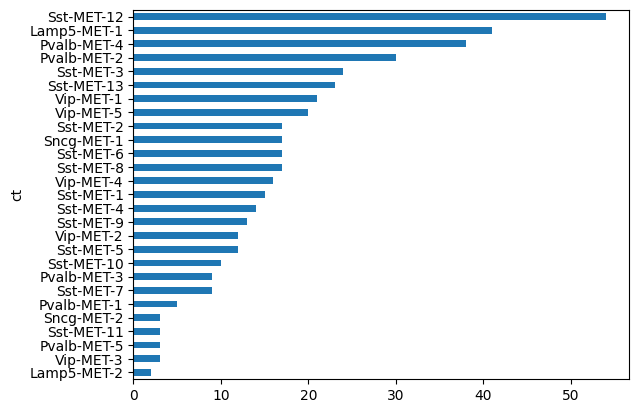

In [14]:
ct_df = pd.DataFrame({'ct':adatas_all[0].obs['cell_type_TEM'].values})
plt.figure()
ct_df.ct.value_counts().sort_values().plot(kind = 'barh')


ModuleNotFoundError: No module named 'autonotebook'

In [15]:

# model.load_model(f"{root_save_path}/train_best.pt",device=torch.device(device))
# model.model.device_in_use = device
losses = model.evaluate(adatas_all,give_losses=True,stage='train')
predict_label = model.predict_label(adatas_all)
adata_fused = model.infer(adatas_all)
adata_fused.obs['label'] = list(adatas_all[0].obs['label'])
adata_fused.obs['label_less'] = [ct.split('-')[0] for ct in adata_fused.obs['label'].values]


EHHHHHHH
EHHHHHHH


/Users/maddox/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
from sklearn.utils.multiclass import unique_labels


pseudo_label = np.array(adata_fused.obs['predicted_label'].values)
cmat = confusion_matrix(adata_fused.obs['label'], pseudo_label)
ri, ci = linear_sum_assignment(-cmat)
ordered_all = cmat[np.ix_(ri, ci)]
major_sub_names = {}
pred_labels_re_order = copy.deepcopy(pseudo_label)
for re_oder,(lb_correct,lb) in enumerate(zip(unique_labels(adata_fused.obs['label'], pseudo_label)[ri],
                                unique_labels(adata_fused.obs['label'], pseudo_label)[ci])):
  idx = pseudo_label==lb
  if any(idx):
    nm = '-'.join(lb_correct.split('-')[:-1])
    if nm in major_sub_names.keys():
      major_sub_names[nm]+=1
    else:
      major_sub_names[nm]=1
    
    pred_labels_re_order[idx] = f'{nm}-{major_sub_names[nm]}-Uni'

adata_fused.obs['predicted_label'] = pred_labels_re_order


FileNotFoundError: [Errno 2] No such file or directory: './figures/major_matching_heatmap.pdf'

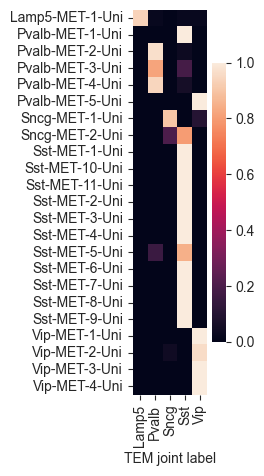

In [19]:
sns.set_style('ticks')
adata_fused.obs['predicted_label_less'] = [ct.split('-')[0] for ct in adata_fused.obs['predicted_label'].values]
cmat = confusion_matrix(adata_fused.obs['predicted_label'], adata_fused.obs['label_less'])
cmat = cmat[:,cmat.sum(axis=0)!=0]
cmat = cmat[cmat.sum(axis=1)!=0,:]
cmat = (cmat.T / cmat.sum(axis=1)).T

fig,ax = plt.subplots(figsize=[1.2,5])
sns.heatmap(cmat,ax=ax,yticklabels=unique_labels(adata_fused.obs['predicted_label']),xticklabels=unique_labels(adata_fused.obs['label_less']),vmin=0, vmax=1)
plt.xlabel('TEM joint label')
plt.savefig('./figures/major_matching_heatmap.pdf')

fig,ax = plt.subplots(figsize=[6,5])
ordered = ordered_all[:,ordered_all.sum(axis=0)!=0]
ordered = ordered[ordered.sum(axis=1)!=0,:]
ordered_re = ordered.T
ordered_norm = (ordered_re.T / ordered_re.sum(axis=1)).T

sns.heatmap(ordered_norm,ax=ax,xticklabels=unique_labels(adata_fused.obs['label']),yticklabels=unique_labels(adata_fused.obs['predicted_label']),vmin=0, vmax=1)
plt.xlabel('TEM joint label')
plt.savefig('./figures/sub_matching_heatmap.pdf')





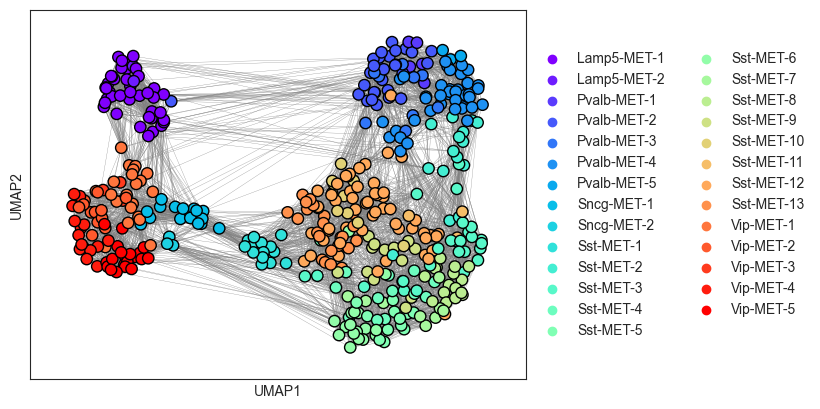

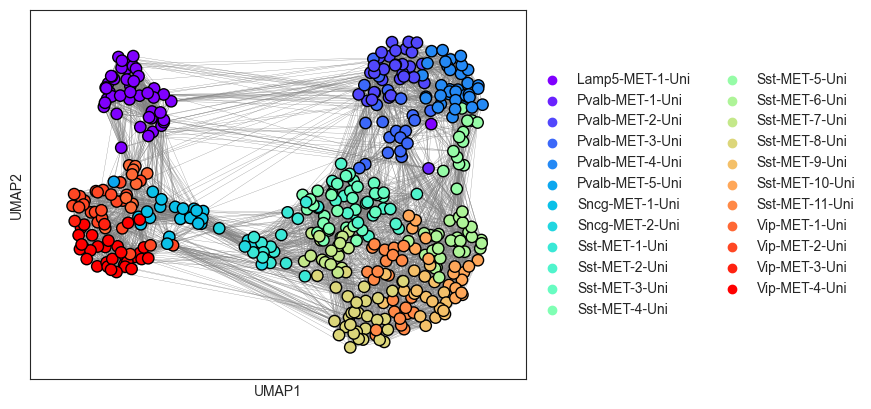

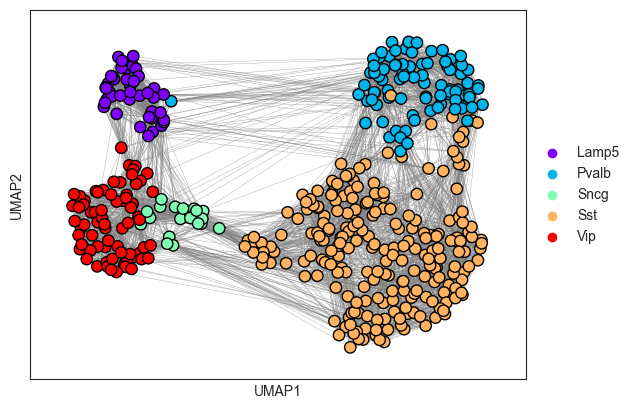

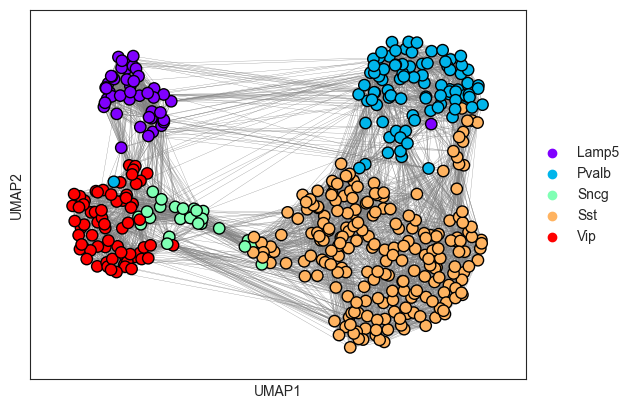

In [26]:

sc.pl.umap(adata_fused, 
           color=['label'], 
           palette='rainbow', 
           show=True, 
           edges=True, 
           edges_width=0.2, 
           edgecolor='k', 
           title='', 
           save='patch_seq_2D_orig_MET.pdf')
sc.pl.umap(adata_fused,
           color=['predicted_label'],
           palette='rainbow',
           show=True,
           edges=True,
           edges_width = 0.2,
           edgecolor='k',
           title='',
           save='patch_seq_2D_Uni_MET.pdf')


sc.pl.umap(adata_fused,color=['label_less'],palette='rainbow',show=True,edges=True,edges_width = 0.2,edgecolor='k',title='',save='patch_seq_2D_MET_comparison.pdf')
sc.pl.umap(adata_fused,color=['predicted_label_less'],palette='rainbow',show=True,edges=True,edges_width = 0.2,edgecolor='k',title='',save='patch_seq_2D_MET_comparison_no_legend.pdf')
